# Natural Agent Mouse Alzheimer Dataset Analysis
# In this analysis, we apply pyVIPER to the natural agent mouse Alzheimer dataset, incorporating the modified ShadowRegulon_py function to correct for pleiotropic effects. This approach allows us to infer protein activity while identifying transcription factors (TFs) that are shadowed due to pleiotropy. We will compare the NES (Normalized Enrichment Score) matrices before and after correction to detect TFs that are downregulated or excluded from the analysis. Additionally, we will visualize and compare the results using UMAPs and heatmaps to highlight the impact of pleiotropy correction. Finally, we will include code to identify and display shadowed TF pairs that were filtered out during the correction process.

#Step 1: Import the following Libraries 


In [1]:
#Import Libraries
import scanpy as sc
import anndata as ad
import os
import pandas as pd
import numpy as np
import pyviper
from scipy.stats import norm
import matplotlib.pyplot as plt
from itertools import combinations 
import glob

/home/friva/miniconda3/envs/alz_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 2: Run ShadowRegulon_py fucntion and return new regulon and df_pairs

The shadowRegulon_py function is designed to correct for pleiotropic effects in transcription factor (TF) activity inference using VIPER. In gene regulatory networks, some TFs may appear artificially significant because they share many target genes with stronger, more influential TFs. This phenomenon,known as pleiotropy, can obscure the true regulatory signals. This function identifies such cases and adjusts the regulon by down-weighting the contribution of shadowed TFs, making protein activity inference more specific and biologically meaningful.

The function takes a gene expression signature (ss), previously computed normalized enrichment scores (nes), and a regulon (TF-target network), and evaluates each TF pair for shadowing using statistical tests. If one TF significantly dominates another over shared targets, the function penalizes the likelihood values of the shadowed TF’s connections. Two methods of correction are available: absolute (based on significance thresholds) and adaptive (based on the magnitude of asymmetry in shadowing). The output is a corrected regulon and a DataFrame listing the shadowing TF pairs and their p-values

In [ ]:
# Run ShadowRegulon_py function

#Parameters:
# ss : pandas.Series, Gene expression signature (gene names as index, expression values as data).   
# nes : pandas.Series, Normalized enrichment scores from a previous VIPER run (TF names as index).
# regul : dict Regulon object ,  dictionary mapping each TF to a dict with 'tfmode' and 'likelihood' values for its target genes.
# regulators : float or int, optional (default=0.05)
    #- If < 1: p-value threshold to select significant regulators based on NES.
    #   - If >= 1: number of top regulators to consider for pleiotropy testing.
    
# shadow : float, optional (default=0.05) P-value threshold for determining significant pleiotropy (shadow) effect.
# targets : int, optional (default=10), Minimum number of overlapping target genes between TF pairs to consider them for pleiotropy analysis.    
# penalty : float, optional (default=2),  Penalization factor to down-weight pleiotropic interactions (must be >1). A value of 1 means no correction. 
# method : str, optional (default='absolute')
    #Method for applying correction:
    #   - 'absolute': penalize TFs that are dominated by another TF with shared targets.
    #   - 'adaptive': penalization is scaled based on the relative strength (p-value) difference.


def shadowRegulon_py(ss, nes, regul, regulators=0.05, shadow=0.05, targets=10, penalty=2, method='absolute'):
    method = method.lower()

    nes = pd.Series(nes) if not isinstance(nes, pd.Series) else nes # Ensure 'nes' is a pandas Series (if not already)
    pval_vals = 2 * norm.sf(np.abs(nes.values)) # Compute two-tailed p-values for each NES using the standard normal distribution
    pval = pd.Series(pval_vals, index=nes.index)  # Create a Series of p-values with TF names as the index
 
 # Determine which transcription factors (TFs) to include based on the 'regulators' parameter
    if regulators < 1:
        tfs = pval[pval < regulators].index.tolist() # If regulators is a float < 1, treat it as a p-value threshold — keep TFs with p-value below this threshold
    else:
        tfs = pval.sort_values().index[:int(regulators)].tolist()  # If regulators is an integer >= 1, select the top N TFs with the smallest p-values
    tfs = [tf for tf in tfs if "--" not in tf]  # Exclude TFs that contain '--', which are usually artifacts or improperly formatted names
    if len(tfs) < 2: 
        return regul    # If fewer than 2 valid TFs are found, return the original regulon unmodified

    result_dict = {} # Dictionary to store pleiotropy test results for TF pairs
    tests = {} # Dictionary to count how many comparisons each TF is involved in


    for tf1 in tfs:  # Loop over each transcription factor (TF) as the "primary" TF
        reg_tmp = {} # Temporary dictionary to store pleiotropy candidates for tf1
        for tf2 in tfs:
            if tf2 == tf1 or tf1 not in regul or tf2 not in regul: # Loop again to compare tf1 with every other TF (tf2)
                continue
            common_targets = set(regul[tf1]["tfmode"]) & set(regul[tf2]["tfmode"]) # Find the set of common target genes between tf1 and tf2

            if len(common_targets) < targets:
                continue
            reg_tmp[tf2] = {
                "tfmode": [regul[tf1]["tfmode"][t] for t in common_targets],
                "likelihood": [regul[tf1]["likelihood"][t] for t in common_targets],
                "names": list(common_targets) 
            } # Store information about the overlap:
            # - tfmode values for common targets (from tf1's perspective)
            # - likelihood values for the same targets
            # - names of the shared target genes

        tf1_targets = list(regul[tf1]["tfmode"].keys())  # Get the list of all target genes regulated by tf1
        ss_tf1 = pd.Series({g: ss[g] for g in tf1_targets if g in ss})  # Create a Series of gene expression signature values for tf1's targets (only those present in 'ss')

        s2 = ss_tf1.rank() / (len(ss_tf1) + 1) * 2 - 1  # Rank-transform and scale s2 to lie in [-1, 1] to reflect activation state
        s1 = np.abs(s2) * 2 - 1  # s1 reflects magnitude of activation regardless of direction, scaled to [-1, 1]
        s1 += (1 - s1.max()) / 2 # Normalize s1 to ensure it has maximum value close to 1 (avoids infinities in next step)

        s1 = pd.Series(norm.ppf(s1 / 2 + 0.5), index=s2.index)  # Transform s1 to a normal distribution using the inverse CDF (probability integral transform)


        sign_nes = np.sign(nes.get(tf1, 1)) or 1   # Determine the sign of tf1's NES (normalized enrichment score); default to +1 if not found
        s2 = pd.Series(norm.ppf(s2 / 2 + 0.5) * sign_nes, index=s2.index) # Convert s2 to normal distribution as well, adjusting sign based on NES direction

        pvals_tf1 = {} # Dictionary to store p-values for pleiotropy between tf1 and each tf2
        for tf2, data in reg_tmp.items(): # List of shared target genes between tf1 and tf2
            genes = data["names"]
            valid_genes = [g for g in genes if g in s1.index] # Filter shared genes to only those also in s1 (i.e., valid for calculation)
            if len(valid_genes) < targets:
                continue # Skip this tf pair if not enough overlapping valid targets
            tfmode_vals = np.array([data["tfmode"][i] for i, g in enumerate(genes) if g in valid_genes]) # Get regulatory mode values for the valid genes
            likelihood_vals = np.array([data["likelihood"][i] for i, g in enumerate(genes) if g in valid_genes]) # Get likelihood/confidence values for the valid genes
            s1_vals = s1[valid_genes].values  # s1 values for the valid genes (directionless activation strength)
            s2_vals = s2[valid_genes].values # s2 values for the valid genes (directional activation strength)

            sum1 = np.sum(tfmode_vals * likelihood_vals * s2_vals)   # Weighted directional score (activation/inhibition with direction)
            sum2 = np.sum((1 - np.abs(tfmode_vals)) * likelihood_vals * s1_vals)  # Weighted undirected penalty based on weak regulation (values close to 0)
            ww = likelihood_vals / np.max(likelihood_vals) # Normalize likelihoods for weighting
            score = (np.abs(sum1) + sum2 * (sum2 > 0)) / np.sum(likelihood_vals) * np.sign(sum1 or 1) * np.sqrt(np.sum(ww ** 2)) # Composite pleiotropy score combining directionality and penalty
            pvals_tf1[tf2] = norm.sf(score)   # Convert score to one-sided p-value (shadow effect from tf2 on tf1)

        result_dict[tf1] = pvals_tf1 # Save all tf2 p-values for this tf1
        tests[tf1] = len(pvals_tf1) # Record how many TFs were tested against tf1

    tf_pairs = list(combinations(tfs, 2))  # Generate all unique unordered pairs of transcription factors (TFs) for pleiotropy testing
    records = []
    for tf1, tf2 in tf_pairs:
        p1 = result_dict.get(tf1, {}).get(tf2, np.nan)
        p2 = result_dict.get(tf2, {}).get(tf1, np.nan) # Retrieve p-values for shadowing from tf2 → tf1 and tf1 → tf2
        if not np.isnan(p1) and not np.isnan(p2):  # Only keep the pair if both directional p-values exist (i.e., were computed)
            records.append((tf1, tf2, p1, p2)) 

    df_pairs = pd.DataFrame(records, columns=["TF1", "TF2", "P12", "P21"])  # Store results in a DataFrame for easy filtering and analysis

    if df_pairs.empty:
        return regul # If no valid TF pairs remain, return the unmodified regulon

    if method == 'absolute':  # Use the "absolute" method to detect asymmetric pleiotropy (one TF masks the other)
        sig_1 = df_pairs[(df_pairs["P12"] < shadow) & (df_pairs["P21"] > shadow)]
        sig_2 = df_pairs[(df_pairs["P21"] < shadow) & (df_pairs["P12"] > shadow)].copy()
        sig_2[["TF1", "TF2"]] = sig_2[["TF2", "TF1"]]
        significant = pd.concat([sig_1, sig_2])

        for _, row in significant.iterrows(): # For each asymmetric pair (tf2 shadows tf1), apply a penalty to tf1's targets
            tf1, tf2 = row["TF1"], row["TF2"]
            if tf1 not in regul or tf2 not in regul:  # Safety check: skip if one of the TFs is missing from the regulon
                continue
            common_genes = set(regul[tf1]["tfmode"]) & set(regul[tf2]["tfmode"])   # Identify overlapping genes regulated by both TFs
            for gene in common_genes:   # Apply penalty only if the gene has a defined likelihood under tf1
                if gene in regul[tf1]["likelihood"]:
                    regul[tf1]["likelihood"][gene] /= penalty ** (1 / tests[tf1]) # Penalize likelihood by reducing its value to down-weight pleiotropic effects

    elif method == 'adaptive':  # If using the "adaptive" method, calculate a directional penalty based on the asymmetry in shadowing
        df_pairs["diff"] = np.log10(df_pairs["P21"] + 1e-10) - np.log10(df_pairs["P12"] + 1e-10) # Compute log-scale difference in p-values for each TF pair to measure asymmetry in shadowing.
        # Small constant 1e-10 added to avoid log(0).
        for _, row in df_pairs.iterrows():
            tf1, tf2 = row["TF1"], row["TF2"]
            if np.isnan(row["diff"]): # Skip the pair if difference could not be computed
                continue
            if row["diff"] > 0:  # tf2 significantly shadows tf1; keep original order
                weight = row["diff"]
            else:
                tf1, tf2 = tf2, tf1   # tf1 shadows tf2; swap direction and take positive weight
                weight = -row["diff"]
            if tf1 not in regul or tf2 not in regul:    # Safety check
                continue
            common_genes = set(regul[tf1]["tfmode"]) & set(regul[tf2]["tfmode"])
            for gene in common_genes:    # Penalize the likelihood of the TF that is being shadowed
                if gene in regul[tf1]["likelihood"]:
                    regul[tf1]["likelihood"][gene] /= (1 + weight) ** (penalty / tests[tf1])  # The penalty is modulated by both the strength of asymmetry (weight) and the number of comparisons (tests[tf1])

    return regul,df_pairs # Return the regulon object with updated (penalized) likelihoods


Step 3: Obtain an ANNDATA object (Containing the gene expression Matrix)

In [6]:
#Obtain an ANNDATA object (Containing the gene expression Matrix)


# Define base directories
base_dir = "/shares/vasciaveo_lab/programs/Alzheimers_Project/"
metacell_dir = os.path.join(base_dir, "d2_adatas")

# Find all *.h5ad paths in that directory
h5ad_paths = sorted(glob.glob(os.path.join(metacell_dir, "*.h5ad")))

# Load each file into an AnnData and store in a list
adatas = [] 
for path in h5ad_paths:
    sample_name = os.path.basename(path).replace(".h5ad", "")
    print(f"Loading {sample_name} from {path}...")
    ad = sc.read_h5ad(path)
    adatas.append(ad)

# Concatenate all AnnData objects into a single AnnData (gene expression matrix)
gene_expr_signature = sc.concat(
    adatas,
    join="inner",
    label="sample",
    keys=[os.path.basename(p).replace(".h5ad", "") for p in h5ad_paths],
    index_unique="-"
)

# Scale the expression values
sc.pp.scale(gene_expr_signature)

# Print shape of the combined matrix
print(gene_expr_signature.shape)


Loading H1 from /shares/vasciaveo_lab/programs/Alzheimers_Project/d2_adatas/H1.h5ad...
Loading H2 from /shares/vasciaveo_lab/programs/Alzheimers_Project/d2_adatas/H2.h5ad...
Loading H3 from /shares/vasciaveo_lab/programs/Alzheimers_Project/d2_adatas/H3.h5ad...
Loading H4 from /shares/vasciaveo_lab/programs/Alzheimers_Project/d2_adatas/H4.h5ad...


/home/friva/miniconda3/envs/alz_env/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


(27101, 16674)


In [7]:

aracne_out_path = os.path.join(base_dir,"d2_a3_output_100_subnets")
pattern = os.path.join(aracne_out_path, "*_aracne", "consolidated-net_defaultid.tsv")
tsv_paths = sorted(glob.glob(pattern))
print("Found these network files:")
for p in tsv_paths:
    print(" ", p)
# Initialize dictionary to store regulons
all_dfs = {}
for p in tsv_paths:
    sample = os.path.basename(os.path.dirname(p)).replace("_aracne", "")
    df = pd.read_csv(p, sep="\t")
    df["sample"] = sample
    all_dfs[sample] = pyviper.pp.aracne3_to_regulon(net_file=None, net_df=df)
for i in all_dfs.values():
    print(i.shape)
tfs = pyviper.load.TFs(species="mouse")
cotfs = pyviper.load.coTFs(species="mouse")
sig = pyviper.load.sig(species="mouse")
surf = pyviper.load.surf(species="mouse")
allowed_regulators = set(tfs + cotfs + sig + surf)

# Combine all sample regulons into a single interactome table
networks = []
for reg_df in all_dfs.values():
    networks.append(pd.DataFrame(reg_df))

net_df = pd.concat(networks, ignore_index=True)

# Convert to pyVIPER Interactome
network_interactome = pyviper.Interactome("alzheimers_integrated", net_df)

# Check structure
print("Number of regulons:", network_interactome.size())
network_interactome.net_table.head()



Found these network files:
  /shares/vasciaveo_lab/programs/Alzheimers_Project/d2_a3_output_100_subnets/H1_aracne/consolidated-net_defaultid.tsv
  /shares/vasciaveo_lab/programs/Alzheimers_Project/d2_a3_output_100_subnets/H2_aracne/consolidated-net_defaultid.tsv
  /shares/vasciaveo_lab/programs/Alzheimers_Project/d2_a3_output_100_subnets/H3_aracne/consolidated-net_defaultid.tsv
  /shares/vasciaveo_lab/programs/Alzheimers_Project/d2_a3_output_100_subnets/H4_aracne/consolidated-net_defaultid.tsv
(275150, 4)
(258800, 4)
(271550, 4)
(267650, 4)
Number of regulons: 5734


,regulator,target,mor,likelihood
0,0610010K14Rik,Tmsb4x,0.874701,0.986281
1,0610010K14Rik,Ubc,0.866890,1.000000
2,0610010K14Rik,Cst3,0.862441,0.960091
3,0610010K14Rik,C1qc,0.847485,0.963870
4,0610010K14Rik,Rps9,0.862953,0.971884


Step 4: Interactome Filtering and Pruning
In this step, we refine the interactome to ensure compatibility with our input gene expression data and improve the biological relevance of the analysis. First, we filter the network to retain only those target genes that are present in our gene expression matrix. Next, we restrict the set of regulators to a curated list of known transcription factors, co-factors, and signaling or surface proteins. Finally, we prune each regulator’s connections to retain only the top 50 high-confidence targets. This filtering and pruning process helps reduce noise, speeds up downstream computations, and ensures that VIPER-based protein activity inference is both accurate and biologically meaningful 

In [8]:
#FILTERING 
# Step 1: Filter targets to those in the gene expression matrix (AnnData)
print("Filtering targets to match gene expression matrix...")
network_interactome.filter_targets(gene_expr_signature.var_names)

# Step 2: Filter regulators to known TFs/coTFs/signal/surface
print("Filtering regulators...")
network_interactome.filter_regulators(regulators_keep=list(allowed_regulators))
print(f"Regulators and targets after filtering: {network_interactome.size()} ; {len(network_interactome.get_target_names())}")

# Step 3: Prune to top 50 targets per regulator
print("Pruning each regulator to top 50 targets...")
network_interactome.prune(max_targets=50)
print(f"After pruning: Regulators = {network_interactome.size()} ; Targets = {len(network_interactome.get_target_names())}")



Filtering targets to match gene expression matrix...
Removed 158553 targets.
Filtering regulators...
Removed 0 targets.
Removed 908863 regulators.
Regulators and targets after filtering: 5734 ; 15838
Pruning each regulator to top 50 targets...
Removed 640697 targets.
Removed 256 regulators.
After pruning: Regulators = 5478 ; Targets = 13079


/home/friva/miniconda3/envs/alz_env/lib/python3.10/site-packages/pyviper/interactome.py:594: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pruned_df = sorted_df.groupby('regulator', group_keys=False).apply(lambda x: x.iloc[:max_targets])


Step 5: Apply pyViper to the original gene expression matrix without applying pleiotropic correction for comparison purposes 

In [9]:
# Make a copy of the full interactome before pruning
network_pruned = network_interactome.copy()

# Prune to the top 50 targets per regulator (recommended for consistent NES values)
network_pruned.prune(max_targets=50, eliminate=True)  # `eliminate=True` removes regulators with <50 targets

# Optionally, check how many targets and regulators are left
print(f"Pruned interactome size (regulators): {network_pruned.size()}")
print(f"Number of unique targets: {len(network_pruned.get_target_names())}")



ProtAct_aREA = pyviper.viper(
    gex_data=gene_expr_signature,     # your AnnData gene expression
    interactome=network_pruned,       # interactome filtered + pruned to 50 targets
    enrichment="area",                # use aREA enrichment
    output_as_anndata=False,           # get results as AnnData for plotting
    njobs=16,                         # run on all your available CPUs
    verbose=True                      # optional: see progress
)




Removed 0 targets.
Removed 0 regulators.
Pruned interactome size (regulators): 5478
Number of unique targets: 13079
Preparing the association scores
Computing regulons enrichment with aREA


/home/friva/miniconda3/envs/alz_env/lib/python3.10/site-packages/pyviper/interactome.py:594: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pruned_df = sorted_df.groupby('regulator', group_keys=False).apply(lambda x: x.iloc[:max_targets])


In [10]:
ProtAct_aREA #NES activity Matrix for original cells

,0610010K14Rik,1700020N01Rik,1810024B03Rik,2010315B03Rik,2610008E11Rik,2610021A01Rik,2610044O15Rik8,2610528A11Rik,2810021J22Rik,2810408A11Rik,...,Zscan22,Zscan25,Zscan26,Zscan29,Zxdb,Zxdc,Zyx,Zzz3,a,mt-Nd2
AAACCCAAGACTAAGT-1-H1,6.613429,0.000293,-2.832635,-4.118581,-5.554859,2.406736,4.484270,6.984068,3.099422,-0.005037,...,2.530804,-3.432321,3.270967,1.297972,3.960217,3.372497,6.790830,-2.165752,-0.193168,1.405902
AAACCCAAGACTGGGT-1-H1,-11.059826,1.219458,-10.317850,-5.546203,-7.960496,-8.135099,-10.158342,-11.120416,-7.856270,-1.164442,...,-8.740548,-5.640201,-5.136618,-5.745931,-8.976750,-9.107364,-10.075879,-8.408278,-1.437163,3.987630
AAACCCAAGAGAGAAC-1-H1,-11.002666,1.059958,-8.529420,-2.897559,-3.822711,-8.443425,-10.184023,-9.877184,-7.730805,-1.422535,...,-8.714347,-6.359871,-4.173551,-6.585726,-9.275832,-8.464604,-9.870096,-5.697065,-1.458840,3.907063
AAACCCAAGAGGTTTA-1-H1,3.580515,-0.002480,2.798592,1.704438,2.933763,2.889262,3.886306,4.404248,3.003721,-0.004871,...,4.108069,2.590345,4.681258,1.952060,4.393861,2.668039,4.341207,3.199037,-0.029529,1.569559
AAACCCAAGCAATAAC-1-H1,-10.621643,0.592464,-7.174995,5.215173,4.864758,4.157305,-7.340583,-8.191273,-6.458858,-0.483683,...,-8.587797,-5.660464,-3.954610,-3.934739,-8.686782,-7.404997,-7.904763,4.231385,1.367966,-5.052751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGATGTAA-1-H4,5.902313,-0.001394,-3.012797,2.372951,-2.008079,-2.521859,3.410199,4.078827,3.278505,-0.004914,...,2.899584,-3.883860,2.289857,1.491629,3.705158,4.393662,4.090440,1.976743,-0.100611,3.967633
TTTGTTGTCACGTCCT-1-H4,-12.554921,1.541879,-11.981029,-13.280859,-12.319690,-11.732697,-11.574495,-11.723587,-7.665526,-2.134879,...,-10.622673,-7.137049,-13.367406,-12.127307,-10.763381,-13.873017,-14.006259,-11.896496,-1.636398,-6.431651
TTTGTTGTCCGCAAAT-1-H4,3.871753,-0.001084,2.845279,3.711810,5.276157,4.752269,3.700885,3.062425,4.573277,-0.004905,...,3.990964,3.217714,2.761805,3.853740,4.393628,2.574041,4.412203,5.613174,0.015660,-6.091872
TTTGTTGTCCGTATAG-1-H4,6.151967,-0.001039,3.619618,3.571209,1.932927,3.659259,4.754954,5.876118,3.656084,-0.004918,...,4.765276,-4.097529,7.587293,4.840244,5.009137,3.584267,5.979866,1.984994,0.034530,0.858550


Step 6: Preparing Inputs for Pleiotropy Correction

In this step, we prepare the required inputs for pleiotropy correction using the ShadowRegulon_py function. First, we compute a gene expression signature by averaging the expression of each gene across all cells in the dataset. Next, we extract the normalized enrichment scores (NES) from the VIPER output—representing inferred protein activities for each transcription factor. Finally, we convert the pruned Alzheimer-specific interactome into a regulon dictionary, mapping each TF to its regulatory mode (tfmode) and confidence (likelihood) for each of its target genes. These inputs are essential for identifying and correcting pleiotropic TF effects in downstream analysis.

In [15]:
signature = pd.Series(
    np.array(gene_expr_signature.X.mean(axis=0)).flatten(),
    index=gene_expr_signature.var_names
)
#  Use NES matrix from the Alzheimer VIPER result
NES_vals = pd.Series(
    ProtAct_aREA.mean(axis=0).values,
    index=ProtAct_aREA.columns
)
# Convert pruned Alzheimer interactome to regulon dict
net_table = network_pruned.net_table
regulon = {}

for tf in net_table['regulator'].unique():
    tf_df = net_table[net_table['regulator'] == tf]
    regulon[tf] = {
        "tfmode": dict(zip(tf_df['target'], tf_df['mor'])),
        "likelihood": dict(zip(tf_df['target'], tf_df['likelihood']))
    }


Step 7: Apply pleiotropic correction

In [ ]:
# Run pleiotropy correction
corrected_regulon, df_pairs = shadowRegulon_py(
    ss=signature,
    nes=NES_vals,
    regul=regulon,
    regulators=0.05,     # broader selection of TFs
    shadow=0.05,        # relaxed shadow threshold
    targets=10,
    penalty=2,
    method='absolute'
)

Rank transforming the data
Preparing the 1-tailed / 2-tailed matrices
Computing the likelihood matrix
Computing the modes matrix
Computing 2-tail enrichment
Computing 1-tail enrichment
Integrating enrichment
Rank transforming the data
Preparing the 1-tailed / 2-tailed matrices
Computing the likelihood matrix
Computing the modes matrix
Computing 2-tail enrichment
Computing 1-tail enrichment
Integrating enrichment
Rank transforming the data
Preparing the 1-tailed / 2-tailed matrices
Computing the likelihood matrix
Computing the modes matrix
Computing 2-tail enrichment
Computing 1-tail enrichment
Integrating enrichment


Step 8: In this step, you have the option to run code that generates a table of transcription factor (TF) shadow pairs identified during pleiotropy correction. To do so, you'll need to carefully adjust key parameters (e.g., regulators, shadow, targets, penalty) to optimize sensitivity and specificity. However, in real biological datasets—such as this Alzheimer mouse model—detecting clear shadow pairs can be challenging. Unlike synthetic datasets, real data contain biological and technical noise, variable expression patterns, and uneven target coverage across TFs. These factors, along with potentially weak pleiotropic signals and low overlap between TF regulons, may prevent the algorithm from identifying significant asymmetric shadowing. As a result, some TFs may appear downregulated not due to pleiotropic masking, but because of low NES scores, limited regulon size, or insufficient expression of their targets in the dataset.



In [ ]:
#sig_1 = df_pairs[(df_pairs["P12"] < 0.3) & (df_pairs["P21"] > 0.3)]
#sig_2 = df_pairs[(df_pairs["P21"] < 0.3) & (df_pairs["P12"] > 0.3)].copy()
#sig_2[["TF1", "TF2"]] = sig_2[["TF2", "TF1"]]
#shadow_pairs_df = pd.concat([sig_1, sig_2])
#shadow_pairs_df["Shadow"] = shadow_pairs_df.apply(lambda row: f"{row['TF1']} -> {row['TF2']}", axis=1)

#print("Detected relaxed-threshold shadow pairs:")
#print(shadow_pairs_df["Shadow"].tolist())


Detected relaxed-threshold shadow pairs:
['Gng7 -> Arhgef4']


Step 9: Prepare the data for running pyVIPER on the pleiotropic corrected dataset

In [14]:

# Convert corrected regulon dict to a net_table DataFrame
rows = []
for tf, reg_data in corrected_regulon.items():
    for target in reg_data['tfmode']:
        rows.append({
            'regulator': tf,
            'target': target,
            'mor': reg_data['tfmode'][target],
            'likelihood': reg_data['likelihood'][target]
        })

corrected_net_table = pd.DataFrame(rows)


# Create new Interactome with pleiotropy-corrected regulon
corrected_interactome = pyviper.Interactome(
    name="alzheimers_corrected",
    net_table=corrected_net_table
)


# Re-run pyVIPER using the pleiotropy-corrected interactome
ProtAct_corrected = pyviper.viper(
    gex_data=gene_expr_signature,       # gene expression AnnData
    interactome=corrected_interactome,  # corrected interactome
    enrichment="area",                  # aREA method
    output_as_anndata=False,            # return as DataFrame
    njobs=16,                           # use 16 CPUs
    verbose=True                        # show progress
)

Preparing the association scores
Computing regulons enrichment with aREA


In [17]:
ProtAct_aREA #NES activity Matrix for original cells
ProtAct_corrected #NES activity Matrix for corrected cells

,0610010K14Rik,1700020N01Rik,1810024B03Rik,2010315B03Rik,2610008E11Rik,2610021A01Rik,2610044O15Rik8,2610528A11Rik,2810021J22Rik,2810408A11Rik,...,Zscan21,Zscan22,Zscan25,Zscan26,Zscan29,Zxdb,Zxdc,Zyx,Zzz3,a
AAACCCAAGACTAAGT-1-H1,5.797181,0.000293,-2.790955,-3.654992,-5.133636,2.352481,4.188169,6.438511,3.064644,-0.005037,...,2.310174,2.501421,-3.432321,2.655079,1.217431,3.794856,3.282480,6.509393,-1.830916,-0.193168
AAACCCAAGACTGGGT-1-H1,-9.750121,1.219458,-10.082788,-4.909899,-7.364951,-7.996811,-9.538035,-10.189471,-7.743729,-1.164442,...,-6.090526,-8.643348,-5.640201,-4.243111,-5.570206,-8.591494,-8.590514,-9.642903,-7.236865,-1.437163
AAACCCAAGAGAGAAC-1-H1,-9.675679,1.059958,-8.340206,-2.575293,-3.560208,-8.265076,-9.547725,-9.062813,-7.618929,-1.422535,...,-5.978744,-8.617277,-6.359871,-3.406445,-6.413149,-8.873762,-8.013266,-9.449447,-4.854290,-1.458840
AAACCCAAGAGGTTTA-1-H1,3.137533,-0.002480,2.714672,1.521917,2.712164,2.785045,3.648886,4.051941,2.964623,-0.004871,...,3.741221,4.067319,2.590345,3.862154,1.833819,4.204295,2.523756,4.115064,2.715578,-0.029529
AAACCCAAGCAATAAC-1-H1,-9.364590,0.592464,-7.040358,4.630433,4.497260,4.005864,-6.874738,-7.541561,-6.361124,-0.483683,...,-4.040659,-8.491347,-5.660464,-3.257142,-3.842244,-8.316783,-7.010770,-7.564456,3.622372,1.367966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGATGTAA-1-H4,5.186683,-0.001394,-2.962865,2.102905,-1.847471,-2.440123,3.147402,3.748883,3.232840,-0.004914,...,3.174174,2.866889,-3.883860,1.881602,1.412188,3.549059,4.165355,3.915631,1.720393,-0.100611
TTTGTTGTCACGTCCT-1-H4,-10.999088,1.541879,-11.723536,-11.830980,-11.416353,-11.486977,-10.850846,-10.846727,-7.556536,-2.134879,...,-11.693510,-10.507804,-7.137049,-10.915612,-11.660515,-10.310484,-13.148927,-13.413473,-10.201590,-1.636398
TTTGTTGTCCGCAAAT-1-H4,3.385450,-0.001084,2.698830,3.309768,4.882747,4.655236,3.469490,2.808694,4.515405,-0.004905,...,2.603870,3.954256,3.217714,2.347818,3.675649,4.203840,2.393621,4.230603,4.798627,0.015660
TTTGTTGTCCGTATAG-1-H4,5.390840,-0.001039,3.542903,3.127279,1.783208,3.585609,4.460458,5.415947,3.609222,-0.004918,...,4.060627,4.713579,-4.097529,6.194126,4.616458,4.793708,3.384691,5.725731,1.679795,0.034530


Rank transforming the data
Preparing the 1-tailed / 2-tailed matrices
Computing the likelihood matrix
Computing the modes matrix
Computing 2-tail enrichment
Computing 1-tail enrichment
Integrating enrichment
Rank transforming the data
Preparing the 1-tailed / 2-tailed matrices
Computing the likelihood matrix
Computing the modes matrix
Computing 2-tail enrichment
Computing 1-tail enrichment
Integrating enrichment
Rank transforming the data
Preparing the 1-tailed / 2-tailed matrices
Computing the likelihood matrix
Computing the modes matrix
Computing 2-tail enrichment
Computing 1-tail enrichment
Integrating enrichment


In [16]:
ProtAct_corrected #NES activity Matrix for corrected cells

,0610010K14Rik,1700020N01Rik,1810024B03Rik,2010315B03Rik,2610008E11Rik,2610021A01Rik,2610044O15Rik8,2610528A11Rik,2810021J22Rik,2810408A11Rik,...,Zscan21,Zscan22,Zscan25,Zscan26,Zscan29,Zxdb,Zxdc,Zyx,Zzz3,a
AAACCCAAGACTAAGT-1-H1,5.797181,0.000293,-2.790955,-3.654992,-5.133636,2.352481,4.188169,6.438511,3.064644,-0.005037,...,2.310174,2.501421,-3.432321,2.655079,1.217431,3.794856,3.282480,6.509393,-1.830916,-0.193168
AAACCCAAGACTGGGT-1-H1,-9.750121,1.219458,-10.082788,-4.909899,-7.364951,-7.996811,-9.538035,-10.189471,-7.743729,-1.164442,...,-6.090526,-8.643348,-5.640201,-4.243111,-5.570206,-8.591494,-8.590514,-9.642903,-7.236865,-1.437163
AAACCCAAGAGAGAAC-1-H1,-9.675679,1.059958,-8.340206,-2.575293,-3.560208,-8.265076,-9.547725,-9.062813,-7.618929,-1.422535,...,-5.978744,-8.617277,-6.359871,-3.406445,-6.413149,-8.873762,-8.013266,-9.449447,-4.854290,-1.458840
AAACCCAAGAGGTTTA-1-H1,3.137533,-0.002480,2.714672,1.521917,2.712164,2.785045,3.648886,4.051941,2.964623,-0.004871,...,3.741221,4.067319,2.590345,3.862154,1.833819,4.204295,2.523756,4.115064,2.715578,-0.029529
AAACCCAAGCAATAAC-1-H1,-9.364590,0.592464,-7.040358,4.630433,4.497260,4.005864,-6.874738,-7.541561,-6.361124,-0.483683,...,-4.040659,-8.491347,-5.660464,-3.257142,-3.842244,-8.316783,-7.010770,-7.564456,3.622372,1.367966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGATGTAA-1-H4,5.186683,-0.001394,-2.962865,2.102905,-1.847471,-2.440123,3.147402,3.748883,3.232840,-0.004914,...,3.174174,2.866889,-3.883860,1.881602,1.412188,3.549059,4.165355,3.915631,1.720393,-0.100611
TTTGTTGTCACGTCCT-1-H4,-10.999088,1.541879,-11.723536,-11.830980,-11.416353,-11.486977,-10.850846,-10.846727,-7.556536,-2.134879,...,-11.693510,-10.507804,-7.137049,-10.915612,-11.660515,-10.310484,-13.148927,-13.413473,-10.201590,-1.636398
TTTGTTGTCCGCAAAT-1-H4,3.385450,-0.001084,2.698830,3.309768,4.882747,4.655236,3.469490,2.808694,4.515405,-0.004905,...,2.603870,3.954256,3.217714,2.347818,3.675649,4.203840,2.393621,4.230603,4.798627,0.015660
TTTGTTGTCCGTATAG-1-H4,5.390840,-0.001039,3.542903,3.127279,1.783208,3.585609,4.460458,5.415947,3.609222,-0.004918,...,4.060627,4.713579,-4.097529,6.194126,4.616458,4.793708,3.384691,5.725731,1.679795,0.034530


Step 10: NES score comparison

In this step, we compared the normalized enrichment scores (NES) before and after applying pleiotropy correction. We aligned the original and corrected NES matrices to ensure consistent TFs and samples, then computed the difference (corrected - original) for each transcription factor. By taking the absolute mean difference, we identified the TFs whose activity was most altered by the correction—highlighting those most affected by potential pleiotropic interactions. This helps prioritize TFs for further investigation, as large shifts in NES may reflect important regulatory refinements introduced by the correction process.


In [18]:
# Convert NES outputs to DataFrames
df_original = ProtAct_aREA  # already a DataFrame since output_as_anndata=False
df_corrected = ProtAct_corrected  # also a DataFrame

# Align both DataFrames on common samples (rows) and regulators (columns)
df_original, df_corrected = df_original.align(df_corrected, join='inner', axis=1)

# Compute NES differences: corrected - original
df_diff = df_corrected - df_original

# Show the top 10 regulators with largest average NES changes after correction
print("Top differences in NES (corrected - original):")
print(df_diff.abs().mean().sort_values(ascending=False).head(10))

# Optional: Save difference matrix to CSV for further analysis
# df_diff.to_csv("NES_difference_matrix_alzheimers.csv")



Top differences in NES (corrected - original):
Rpl5        1.878454
Rpl7        1.846747
Leprot      1.787391
Bmyc        1.714449
Pttg1ip     1.682407
Tnfrsf1a    1.628793
Cd151       1.616489
Prdx5       1.613840
Edf1        1.604129
Rer1        1.594321
dtype: float64


Step 12: Analyze single-cells at the PRotein Activity Level

Umaps and Heat maps are used to infer protein activity in this step 

In [21]:
# Set species for transcription factor annotations in pyVIPER (important for filtering TFs correctly)
pyviper.config.set_regulators_species_to_use(species="mouse")

import anndata as ad

# --- Convert NES matrices to AnnData objects for compatibility with scanpy and pyviper functions ---
ProtAct_aREA = ad.AnnData(ProtAct_aREA)
ProtAct_corrected = ad.AnnData(ProtAct_corrected)
# --- Set random seed for reproducibility in PCA and clustering ---
import random
random.seed(0)
# --- Run PCA on both original and corrected datasets, filtering only TFs and co-TFs ---
# This reduces dimensionality and ensures analysis is focused on regulatory proteins
pyviper.tl.pca(ProtAct_aREA, layer=None, filter_by_feature_groups=["tfs", "cotfs"], zero_center=True, svd_solver='arpack', random_state=0)
pyviper.tl.pca(ProtAct_corrected, layer=None, filter_by_feature_groups=["tfs", "cotfs"], zero_center=True, svd_solver='arpack', random_state=0)

# --- Compute neighborhood graphs for both datasets based on correlation of PCA embeddings ---
# This is a prerequisite for clustering (Leiden) and UMAP visualization

sc.pp.neighbors(ProtAct_aREA, metric="correlation", n_neighbors=20, n_pcs=50, random_state=0) 
sc.pp.neighbors(ProtAct_corrected, metric="correlation", n_neighbors=20, n_pcs=50, random_state=3) 

# --- Perform Leiden clustering on both datasets to identify cell groups based on protein activity patterns ---
# Using the same random_state ensures cluster comparison is fair

import leidenalg 
import igraph as ig
sc.tl.leiden(ProtAct_aREA, resolution=0.1, n_iterations=-1, random_state=1) # random staste = 1 for better comparison betweeen corrected and original 
sc.tl.leiden(ProtAct_corrected, resolution=0.1, n_iterations=-1, random_state=1) 


# --- Compute UMAP for low-dimensional visualization of both datasets ---
# This will help visualize clustering and how pleiotropy correction affects global structure
sc.tl.umap(ProtAct_aREA, random_state=0) 
sc.tl.umap(ProtAct_corrected, random_state=0) 


/home/friva/miniconda3/envs/alz_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/home/friva/miniconda3/envs/alz_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/tmp/ipykernel_1872046/1103721437.py:28: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(ProtAct_aREA, resolution=0.1, n_iterations=-1, random_state=1) # random staste = 1 for better comparison betweeen corrected and original


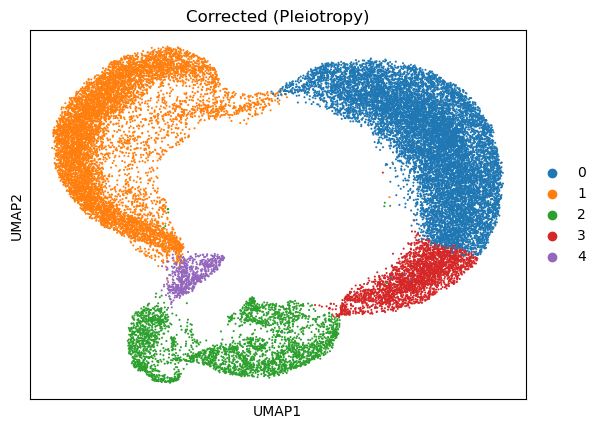

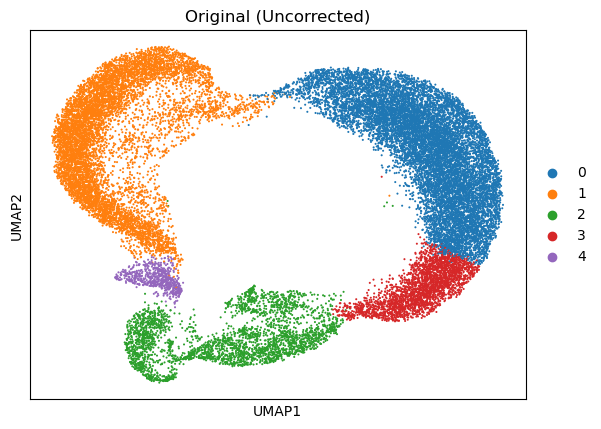

In [22]:
# Define the dot size dynamically based on number of cells
n_cells_corrected = ProtAct_corrected.shape[0]
n_cells_original = ProtAct_aREA.shape[0]  # or use ProtAct_original if that's what you prefer

dot_size_corrected = 120000 / n_cells_corrected * 2
dot_size_original = 120000 / n_cells_original * 2

# Plot UMAPs
sc.pl.umap(ProtAct_corrected, color='leiden', title='Corrected (Pleiotropy)', size=dot_size_corrected)
sc.pl.umap(ProtAct_aREA, color='leiden', title='Original (Uncorrected)', size=dot_size_original)




In [23]:
# --- Compute integrated NES values using Stouffer's method across Leiden clusters ---
# This aggregates protein activity across cells in each cluster to generate a summary NES per TF
NES_integrated = pyviper.pp.stouffer(ProtAct_aREA, "leiden", filter_by_feature_groups=["tfs","cotfs"], compute_pvals=False, return_as_df=True) # Stouffer integration 
NES_integrated 

filtered_proteins = NES_integrated.columns[~NES_integrated.columns.str.startswith('RP')].to_list() # Exclude columns starting with 'RP' from integrated matrix
NES_integrated = NES_integrated.loc[:,filtered_proteins] # remove ribosomal proteins from DataFrame


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.18it/s]


In [ ]:
active_proteins = NES_integrated.apply(lambda row: row.nlargest(10).index.tolist(), axis=1)  # the top 10 most activated proteins in each cell type
active_proteins
# Get the complete list of proteins to plot
protein_set = active_proteins.sum()




In [28]:

#Analize which proteins between the top 10 most activated in each cluster where downregulated after using the pleiotropic correction to remove them form the heat map and obtaining a comparable maps between corrected and original

missing = [gene for gene in protein_set if gene not in ProtAct_corrected.var_names]
print("Missing proteins due to pleiotropy correction:", missing)


Missing proteins due to pleiotropy correction: ['Ang', 'Ctc1', 'Creg1', 'Wwox', 'Hdac8', 'Rpl23', 'Rps3', 'Tpt1', 'Naca', 'Ang', 'Naca', 'Rpl23', 'Rps3', 'Creg1']


In [ ]:
# Remove proteins missing from the corrected dataset
missing_proteins = ['Ang', 'Ctc1', 'Creg1', 'Wwox', 'Hdac8', 'Rpl23', 'Rps3', 'Tpt1', 'Naca']
protein_set_filtered = [gene for gene in protein_set if gene not in missing_proteins]

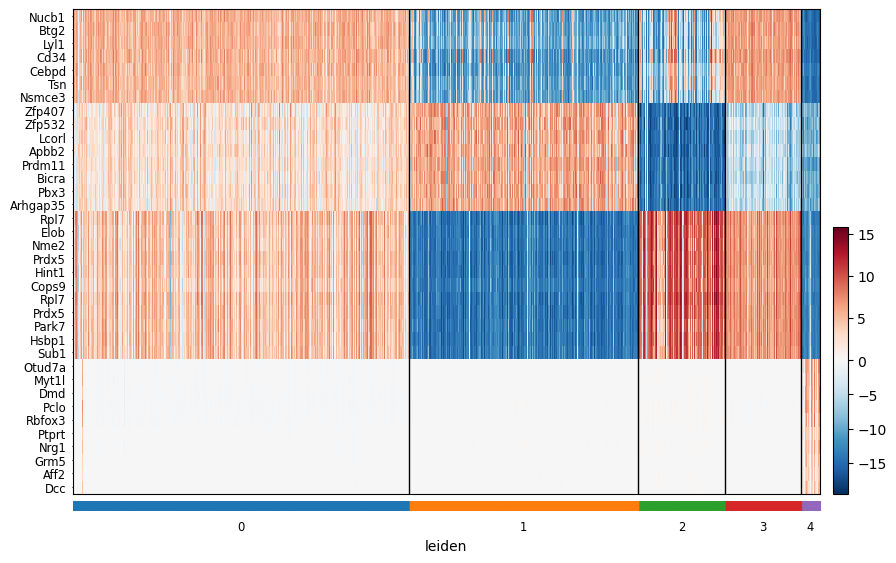

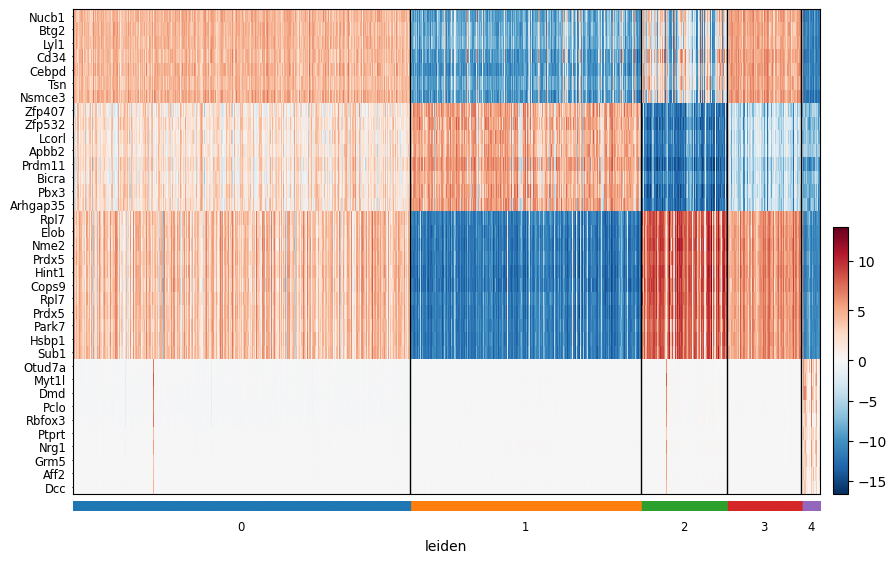

In [30]:
# Plot heatmap for original data
ax_aREA = pyviper.pl.heatmap(
    ProtAct_aREA,
    var_names=protein_set_filtered,
    groupby="leiden",
    vcenter=0,
    cmap="RdBu_r",
    dendrogram=False,
    swap_axes=True,
    show_gene_labels=True
)

# Plot heatmap for corrected data (same filtered protein set)
ax_corrected = pyviper.pl.heatmap(
    ProtAct_corrected,
    var_names=protein_set_filtered,
    groupby="leiden",
    vcenter=0,
    cmap="RdBu_r",
    dendrogram=False,
    swap_axes=True,
    show_gene_labels=True
)